## Obenhaus et al. - Fig. 2 and S2

Behavioral data pertaining to Figure 2 and Figure S2
- panels B and C of Figure 2 
- panels A to D of Figure S2

In [1]:
import sys, os
sys.path.append('..')
import datajoint as dj
import numpy as np
import pandas as pd
from IPython.display import display
%config InlineBackend.figure_format = 'retina'

In [2]:
from dj_schemas.utils import *

Connecting horsto@kavlidatajoint02.it.ntnu.no:3306


In [3]:
# Make plots pretty 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

In [4]:
# To prevent bug in figure export as pdf: 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from mpl_toolkits.axes_grid1 import make_axes_locatable
def now():
    # New time every minute
    return datetime.strftime(datetime.now(),'%d_%m_%Y %H_%M')

In [5]:
figure_dir = '../YOUR_EXPORT_DIRECTORY'

### Do some filtering

In [6]:
all_animals = [
            '90222','90218','90647',
            '82913','88592','89622',
            '87244','89841','60480',
            '87245','87187','88106',
            '94557','97045','97046',
            ] 
print(f'Number of animals in study: {len(set(all_animals))}')

entries = (Session 
           * Session.SessionType 
           * Session.Apparatus 
           * Tracking.OpenField.proj('speed') 
           * Occupancy 
            & 'sessiontype LIKE "Open Field%"' 
            & [f'apparatus = "{app}"' for app in ['Square80']] 
            & [f'animal_name = {an}' for an in all_animals]
            & 'occupancy_time > 0'
            & cell_parameter_dict
            )
print(f'Number of sessions: {len(entries)}')

Number of animals in study: 15
Number of sessions: 203


In [7]:
duration = ((TrackingRaw & entries).proj(duration='TIMESTAMPDIFF(SECOND, start_time, stop_time)')).fetch(as_dict=True)
duration = pd.DataFrame(duration)

In [8]:
duration.duration.mean(), duration.duration.std()

(1452.9802955665025, 610.6409144026352)

### Loop over sessions and collect speed stats

In [9]:
# Loop over sessions and collect average, ... 
# of speed 

average_speed = []
max_speed = []
animals = []
session_orders = []
timestamps = []
genes = []
for entry in tqdm(entries):
    average_speed.append(np.mean(entry['speed']))
    max_speed.append(np.percentile(entry['speed'],95))
    session_orders.append(entry['session_order'])
    animals.append('__'+entry['animal_name']+'__')
    timestamps.append(entry['timestamp'])
    
    genotype = (Animal * Genotype & entry).fetch('gene')
    transgenic= False
    for gene in genotype:
        if 'CK2' in gene:
            transgenic = True

    genes.append(['transgenic' if transgenic else 'wt'][0])

  0%|          | 0/203 [00:00<?, ?it/s]

In [10]:
df_ = pd.DataFrame(np.vstack((animals, session_orders, timestamps, genes, average_speed, max_speed)).T,
                   columns=['animal', 'session_order', 'Timestamp', 'genotype', 'Average', 'Max'])
df_.Average = df_.Average.values.astype(float)
len(df_)

203

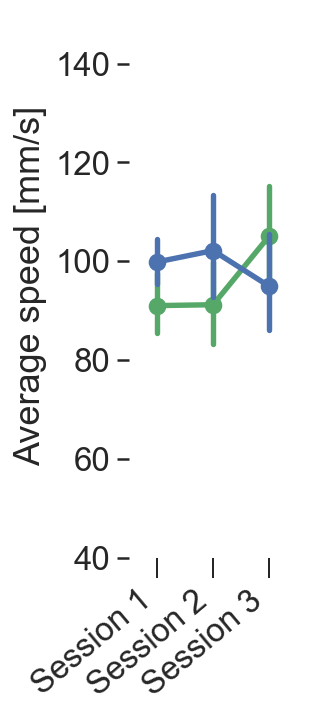

In [11]:
sns.set(style='white',font_scale=1.5)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

figure = plt.figure(figsize=(1.5,5))
my_pal = {"transgenic": "g", "wt": "b"}
g = sns.pointplot(x="session_order", y="Average",\
                  data=df_,
                  hue='genotype', 
                  palette=my_pal, 
                  ci=99,
                  orient='v')
g.legend_.remove()
plt.ylim(40,150)
plt.xlabel('')
plt.ylabel('Average speed [mm/s]')
plt.xticks(np.arange(3), ('Session 1', 'Session 2', 'Session 3'))
plt.xticks(rotation=40, ha='right')
sns.despine(left=True, bottom=True)
figure.savefig(figure_dir + '/comparison_behavior_over_sessions.pdf', bbox_inches='tight')

#### ... and test for significance

In [12]:
from scipy.stats import mannwhitneyu

In [13]:
from Paper_topography_figures.general import get_star

In [14]:
no_1 = 2
no_2 = 0

values_1 = df_[df_.session_order == no_1].Average
values_2 = df_[df_.session_order == no_2].Average
mw_u, mw_p = mannwhitneyu(values_1, values_2)
sig = get_star(mw_p)
print(f'Mann-Whitney U={mw_u:.3f}, n1={len(values_1)}, n2={len(values_2)}, p={mw_p:.6f}{sig} two-sided')

Mann-Whitney U=1531.000, n1=32, n2=123, p=0.026823* two-sided


In [15]:
values_1 = df_[df_.session_order == 0].Average
values_2 = df_[df_.session_order == 1].Average
values_3 = df_[df_.session_order == 2].Average
from scipy.stats import kruskal
kruskal(*[values_1,values_2,values_3])

KruskalResult(statistic=3.680832614795463, pvalue=0.158751322998105)

In [16]:
# How many see
len(values_1), len(values_2), len(values_3)

(123, 48, 32)

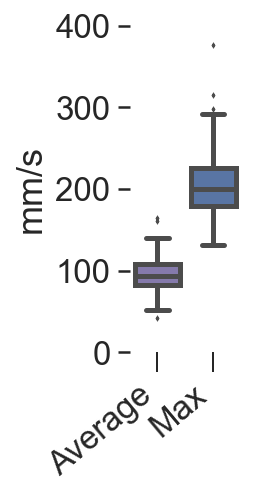

In [17]:
### sns.set(style='white',font_scale=1.5)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
figure = plt.figure(figsize=(1,3))
my_pal = {"Max": "b", "Average": "m"}

sns.boxplot(data=df_[['Average','Max']], width=.8, fliersize=1, palette=my_pal, linewidth=2.5,color='b')
plt.ylabel('mm/s')
plt.xticks(rotation=40, ha='right')
plt.ylim(0,400)
sns.despine(left=True,bottom=True)
figure.savefig(figure_dir + '/comparison_behavior_average_max.pdf', bbox_inches='tight')

In [18]:
np.mean(df_['Max']), np.std(df_['Max'])

(203.68305131467474, 37.45375057458894)

In [19]:
np.mean(df_['Average']), np.std(df_['Average'])

(94.74079823621628, 20.6315907435906)

In [20]:
occupancy_time = (Occupancy & entries.proj()).fetch('occupancy_time')
fraction_occupancy = (Occupancy & entries.proj()).fetch('fraction_occupancy')

In [21]:
len(fraction_occupancy)

203

In [22]:
np.mean(fraction_occupancy)

0.9148171411208798

In [23]:
np.std(fraction_occupancy)

0.08810277054150491

In [24]:
np.mean(occupancy_time)

1304.755865758821

In [25]:
np.std(occupancy_time)

479.8020602911828

### Time running [s] and percentage of time spent exploring

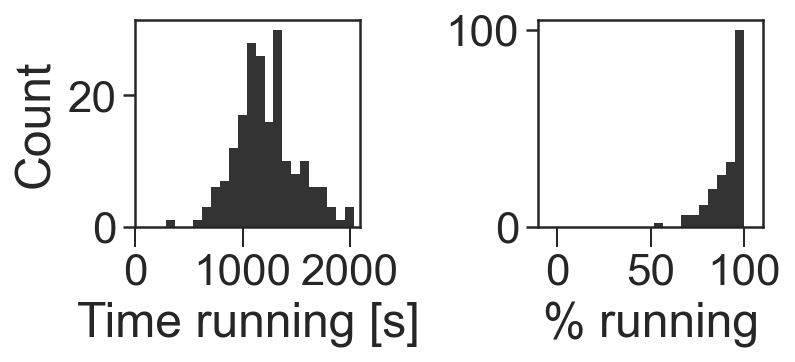

In [26]:
sns.set(style='white', font_scale=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

figure = plt.figure(figsize=(6,3))
ax = figure.add_subplot(121)
ax.hist(occupancy_time, lw=0, color='#333', bins=40);
ax.set_xticks([0,1000,2000])
ax.set_xlim(0,2100)
ax.set_xlabel('Time running [s]')
ax.set_ylabel('Count')

ax = figure.add_subplot(122)
ax.hist(fraction_occupancy*100, lw=0, color='#333');
ax.set_xticks([0,50,100])
ax.set_xlim(-10,110)
ax.set_xlabel('% running')
plt.tight_layout()
figure.savefig(figure_dir + '/Time running.pdf', bbox_inches='tight')

In [27]:
bad_sessions = Occupancy & entries.proj() & 'explor_std > 6' & 'explor_ratio < .7' & cell_parameter_dict
print(len(bad_sessions))
keys = bad_sessions.fetch('KEY', order_by='rand()')

11


In [28]:
from dj_plotter import dj_plotter

Drawing path-spike plots:   0%|          | 0/2 [00:00<?, ?it/s]

Saving figure under ../YOUR_EXPORT_DIRECTORY


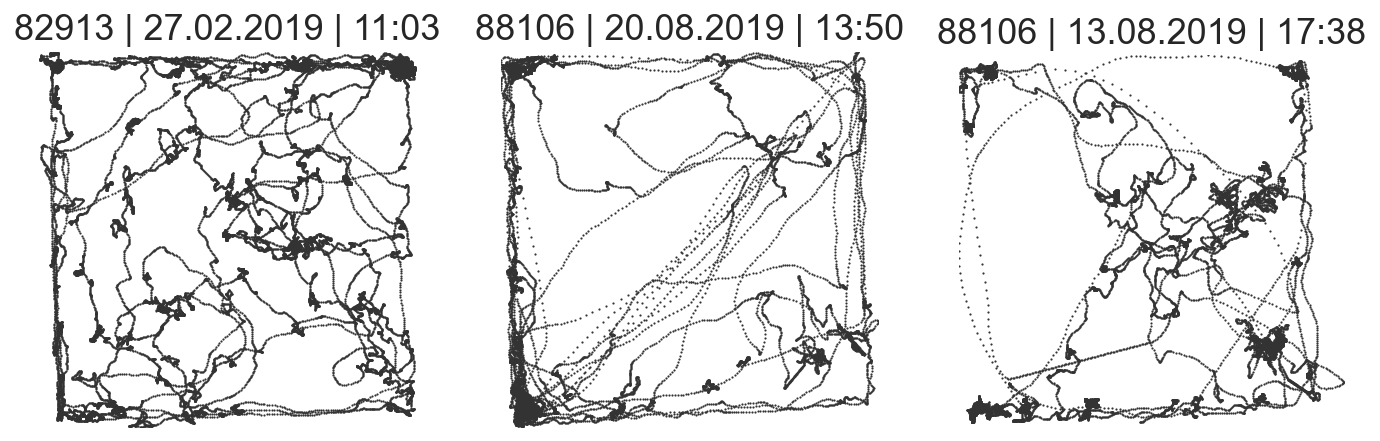

<Figure size 1440x1440 with 0 Axes>

In [29]:
some_path = Session * Tracking.OpenField 
plot = dj_plotter(some_path, keys=keys, total=3, plots_per_view=3, font_scale=1.5, save_path=figure_dir, save_format='png')
plot.tracking(draw_speed=False, hash_or_animal='animal', 
              draw_angle=False,  
              display_title=True)

In [30]:
good_sessions = Occupancy & entries.proj() & 'explor_std < 3' & 'explor_ratio > .9' & cell_parameter_dict
print(len(good_sessions))
keys = good_sessions.fetch('KEY', order_by='RAND()')

38


Drawing path-spike plots:   0%|          | 0/2 [00:00<?, ?it/s]

Saving figure under ../YOUR_EXPORT_DIRECTORY


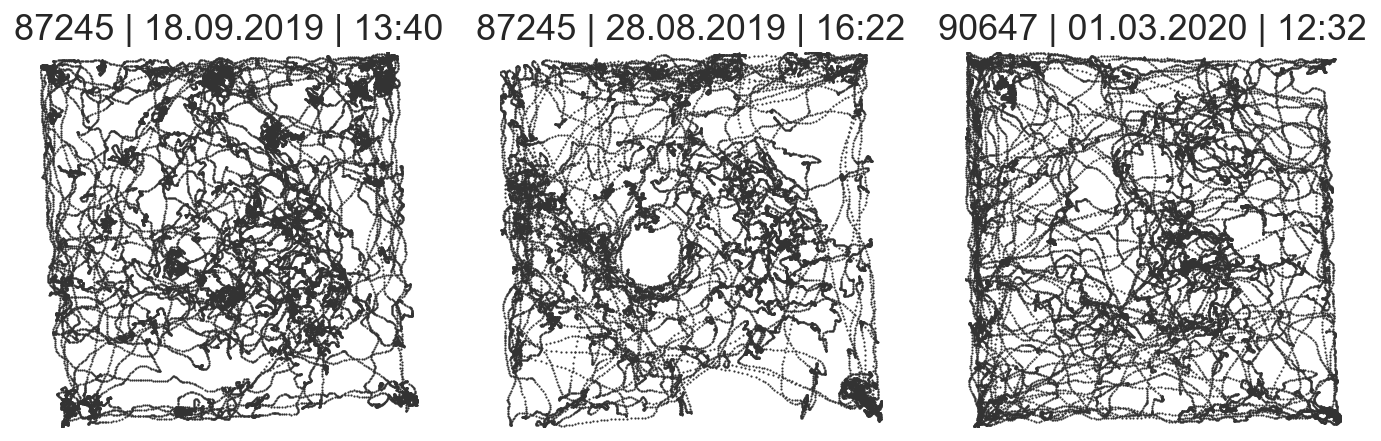

<Figure size 1440x1440 with 0 Axes>

In [31]:
some_path = Session * Tracking.OpenField 
plot = dj_plotter(some_path, keys=keys, total=3, plots_per_view=3, font_scale=1.5, save_path=figure_dir, save_format='png')
plot.tracking(draw_speed=False, hash_or_animal='animal', 
              draw_angle=False,  
              display_title=True)

### Scatter plot in Figure 2 C

In [32]:
entries_STUDY = (Session 
                   * Session.SessionType 
                   * Session.Apparatus 
                   * Tracking.OpenField.proj('speed') 
                   * Occupancy 
                    & 'sessiontype LIKE "Open Field%"' 
                    & [f'apparatus = "{app}"' for app in ['Square80']] 
                    & [f'animal_name = {an}' for an in all_animals]
                    & 'occupancy_time > 0'
                    & cell_parameter_dict)

In [33]:
entries_df = pd.DataFrame(entries_STUDY.fetch(as_dict=True))

# Loop over all entries in dataframe 
# and collect only those entries (TRUE) that are in study 
study_column = []
for row, entry in entries_df.iterrows():
    if len(entries_STUDY.proj() & entry.to_dict()):
        study_column.append('Core animals')
    else:
        study_column.append('')
entries_df['animal_in_study'] = study_column
entries_df.reset_index(inplace=True)

<Figure size 504x504 with 0 Axes>

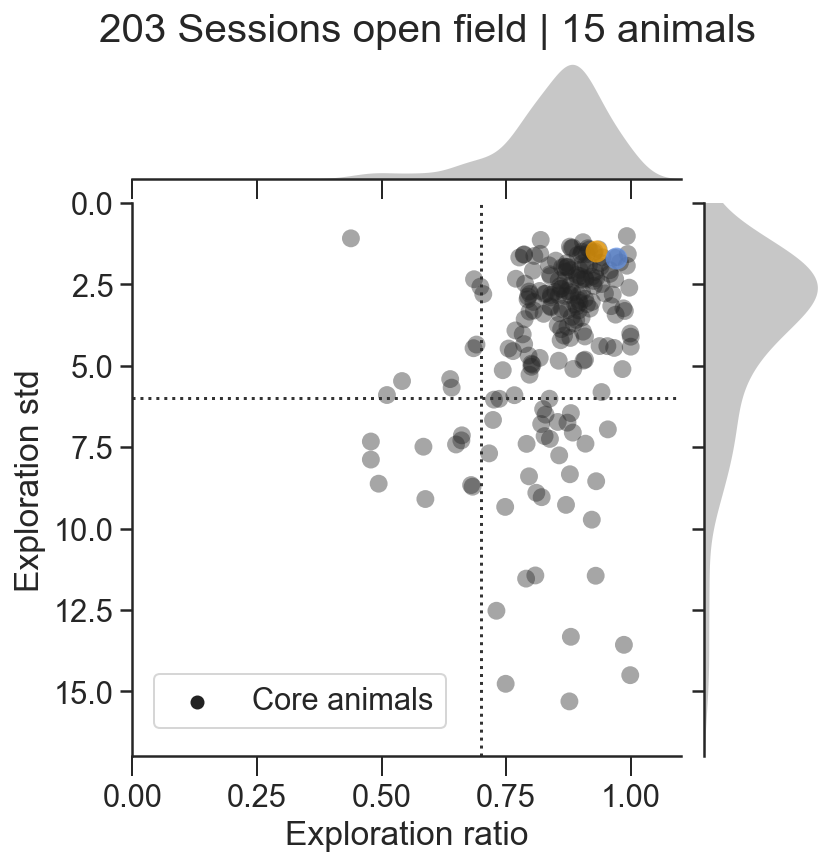

In [34]:
sns.set(font_scale=1.4) 
sns.set_style('white')
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
figure=plt.figure(figsize=(7,7))

# Blue: ,'#4081D3'
g = sns.jointplot(x='explor_ratio', y='explor_std', hue='animal_in_study',  palette=['#222'], 
                   data=entries_df, kind="scatter", ratio=4,
                   joint_kws={'linewidth': 0, 's': 80, 'marker':'o', 'alpha': .4}, 
                   marginal_kws={'lw': 0, 'common_norm': False, 'gridsize': 400, 'bw_method': .35})
g.ax_joint.axhline(y=6, ls=':', color='#333')
g.ax_joint.axvline(x=.7,ls=':',color='#333')
g.ax_joint.set_xlim(0,1.1)
g.ax_joint.set(ylim=(17,0),xlabel='Exploration ratio',ylabel='Exploration std')
g.fig.suptitle('{} Sessions open field | {} animals'.format(len(entries_df), len(set(entries_df.animal_name))),y=1.01)

# Draw example points
g.ax_joint.scatter(0.93,1.49,marker='o', color='orange',lw=0, s=120, alpha=.7)
g.ax_joint.scatter(0.97,1.68,marker='o', color='cornflowerblue', lw=0, s=120, alpha=.7)


g.ax_joint.legend(loc='center right', bbox_to_anchor=(.6, 0.1), ncol=1)

plt.show()
g.savefig(figure_dir + '/behavior.pdf', bbox_inches='tight')